In [51]:
import pandas as pd
import numpy as np;
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, make_scorer, recall_score, precision_score

from imblearn.pipeline import make_pipeline as make_pipeline_imb 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

import warnings
warnings.filterwarnings('ignore')

In [52]:
df=pd.read_csv("creditcard.csv")
print("İlk 5 satır:")
df.head()

İlk 5 satır:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [53]:
print(f"Boyut: {df.shape}\n")

print("Sütün bilgileri:")
print(df.info())

print("İstatistiksel özet:")
print(df.describe())

Boyut: (284807, 31)

Sütün bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     28

In [54]:
print("Tekrar eden satır sayısı:")
df.duplicated().sum()

Tekrar eden satır sayısı:


np.int64(1081)

In [55]:
print("Eksik değer kontrolü:")
print(df.isnull().sum())

Eksik değer kontrolü:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [56]:
print(f"Orijinal Boyut: {df.shape}")
df.drop_duplicates(inplace=True)
print(f"Duplicates Silindi, Yeni Boyut: {df.shape}")

Orijinal Boyut: (284807, 31)
Duplicates Silindi, Yeni Boyut: (283726, 31)


In [57]:
class_counts = df['Class'].value_counts()
print(f"\nSınıf dağılımı:\n{class_counts}")

class_percentages = df['Class'].value_counts(normalize=True) * 100
print(f"\nSınıf yüzdeleri:\n{class_percentages}")

print(f"0= Normal işlemler: {class_counts[0]} ({class_percentages[0]:.2f}%)")
print(f"1= Dolandırıcılık işlemleri: {class_counts[1]} ({class_percentages[1]:.2f}%)")


Sınıf dağılımı:
Class
0    283253
1       473
Name: count, dtype: int64

Sınıf yüzdeleri:
Class
0    99.83329
1     0.16671
Name: proportion, dtype: float64
0= Normal işlemler: 283253 (99.83%)
1= Dolandırıcılık işlemleri: 473 (0.17%)


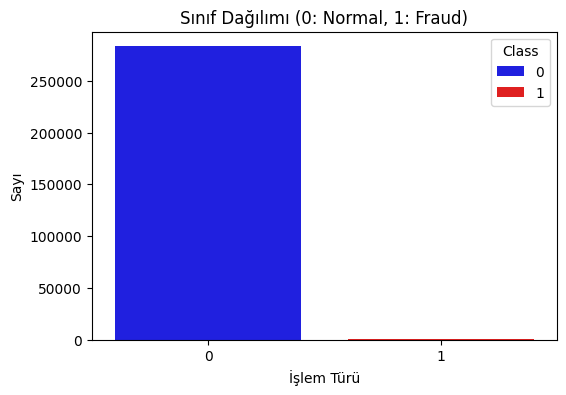

In [58]:
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, hue='Class', palette=['blue', 'red'])
plt.title('Sınıf Dağılımı (0: Normal, 1: Fraud)')
plt.xlabel('İşlem Türü')
plt.ylabel('Sayı')
plt.show()

In [59]:
imbalenced_ratio = class_counts[0] / class_counts[1]
print(f"\nSınıf dengesizliği oranı (Normal/Fraud): {imbalenced_ratio:.2f}")


Sınıf dengesizliği oranı (Normal/Fraud): 598.84


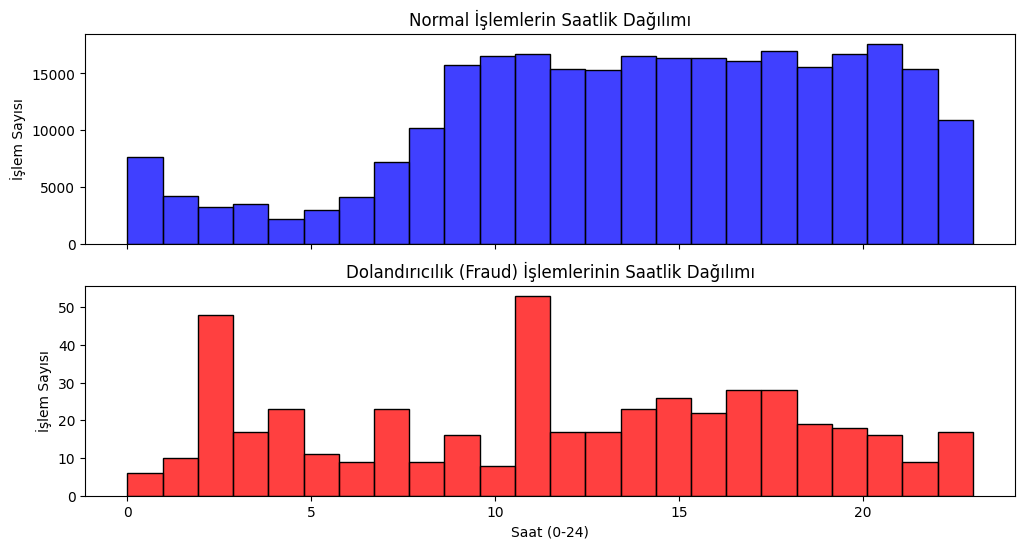

In [60]:
df["Hour"] = (df["Time"] // 3600) % 24
df=df.drop(columns=['Time'], axis=1)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.histplot(df[df['Class'] == 0]['Hour'], bins=24, color='blue', ax=ax1, kde=False)
ax1.set_title('Normal İşlemlerin Saatlik Dağılımı')
ax1.set_ylabel('İşlem Sayısı')

sns.histplot(df[df['Class'] == 1]['Hour'], bins=24, color='red', ax=ax2, kde=False)
ax2.set_title('Dolandırıcılık (Fraud) İşlemlerinin Saatlik Dağılımı')
ax2.set_xlabel('Saat (0-24)')
ax2.set_ylabel('İşlem Sayısı')

plt.show()

In [61]:
df["Amount_log"] = np.log1p(df["Amount"])
df=df.drop(columns=['Amount'], axis=1)

In [62]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Eğitim setindeki Boyutu:", X_train.shape)
print("Test setindeki Boyutu:", X_test.shape)

Eğitim setindeki Boyutu: (226980, 30)
Test setindeki Boyutu: (56746, 30)


In [63]:
model_results = {}

def run_model_scenario(pipeline, X_train, y_train, X_test, y_test, name):
    print(f"\n{'='*20} {name} {'='*20}")
    
    kf=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {'recall': 'recall', 'precision': 'precision', 'f1': 'f1'}
    cv_results = cross_validate(pipeline, X_train, y_train, cv=kf, scoring=scoring,n_jobs=-1)
    
    print(f"Ortalama Recall: {cv_results['test_recall'].mean():.4f}")
    print(f"Ortalama Precision: {cv_results['test_precision'].mean():.4f}")
    print(f"Ortalama F1-Score: {cv_results['test_f1'].mean():.4f}")
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    print("\nTest Seti Performans Raporu:")
    print(classification_report(y_test, y_pred, digits=4))
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    model_results[name] = {
        'recall': recall,
        'precision': precision,
        'auc': pr_auc,
        'y_test': y_test,
        'y_pred': y_pred
    }

In [64]:

# 1. BASELINE 
rf_base = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
pipe_base = make_pipeline_imb(rf_base)
run_model_scenario(pipe_base, X_train_scaled, y_train, X_test_scaled, y_test, "Baseline (RF)")

# 2. CLASS WEIGHTS 
rf_weighted = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
pipe_weighted = make_pipeline_imb(rf_weighted)
run_model_scenario(pipe_weighted, X_train_scaled, y_train, X_test_scaled, y_test, "Class Weights (RF)")

# 3. SMOTE 
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
pipe_smote = make_pipeline_imb(SMOTE(random_state=42), rf_smote)
run_model_scenario(pipe_smote, X_train_scaled, y_train, X_test_scaled, y_test, "SMOTE (RF)")

# 4. SMOTE + TOMEK
rf_st = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
pipe_st = make_pipeline_imb(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=42), rf_st)
run_model_scenario(pipe_st, X_train_scaled, y_train, X_test_scaled, y_test, "SMOTE + Tomek (RF)")


==================== Baseline (RF) ====================
Ortalama Recall: 0.7804
Ortalama Precision: 0.9283
Ortalama F1-Score: 0.8461

Test Seti Performans Raporu:
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56651
           1     0.9583    0.7263    0.8263        95

    accuracy                         0.9995     56746
   macro avg     0.9789    0.8631    0.9130     56746
weighted avg     0.9995    0.9995    0.9995     56746


==================== Class Weights (RF) ====================
Ortalama Recall: 0.7487
Ortalama Precision: 0.9448
Ortalama F1-Score: 0.8324

Test Seti Performans Raporu:
              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9997     56651
           1     0.9710    0.7053    0.8171        95

    accuracy                         0.9995     56746
   macro avg     0.9853    0.8526    0.9084     56746
weighted avg     0.9995    0.9995    0.9994     56746


============

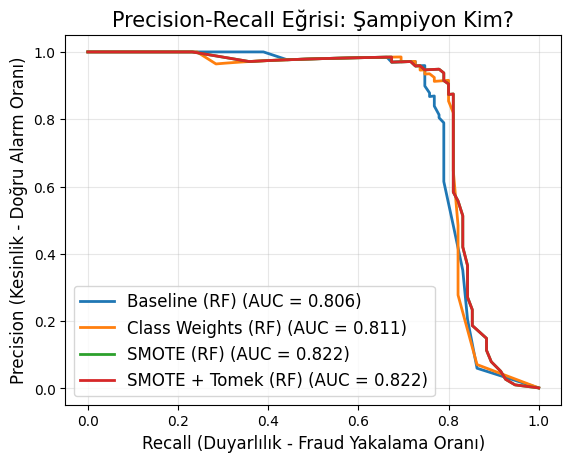

In [65]:
summery_list = []
for name, metrics in model_results.items():
    y_test = metrics['y_test']
    y_pred = metrics['y_pred']
    
    recall=recall_score(y_test, y_pred)
    precision=precision_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred)
    auc_score=metrics['auc']
    
    summery_list.append([name, recall, precision, f1, auc_score])

df_summary = pd.DataFrame(summery_list, columns=['Model', 'Recall', 'Precision', 'F1-Score', 'AUC-PR'])
df_summary = df_summary.sort_values(by='Recall', ascending=False).reset_index(drop=True)

for name, metrics in model_results.items():
    plt.plot(metrics['recall'], metrics['precision'], lw=2, 
             label=f'{name} (AUC = {metrics["auc"]:.3f})')  
    
    
plt.xlabel('Recall (Duyarlılık - Fraud Yakalama Oranı)', fontsize=12)
plt.ylabel('Precision (Kesinlik - Doğru Alarm Oranı)', fontsize=12)
plt.title('Precision-Recall Eğrisi: Şampiyon Kim?', fontsize=15)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()
    